# Sales Forecast

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
import re
from collections import Counter
import holidays
from sklearn.cluster import KMeans
from scipy import stats
from dateutil.relativedelta import relativedelta
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
# Read in the data
def read_data(path):
    df = pd.read_excel(path, sheet_name=['Year 2009-2010', 'Year 2010-2011'], dtype={'Customer ID': str})
    # concat two sheets
    data = pd.concat([df['Year 2009-2010'], df['Year 2010-2011']])
    data.reset_index(inplace=True, drop=True)
    # change column types
    data['Customer ID'] = data['Customer ID'].astype('string')
    data['StockCode'] = data['StockCode'].apply(lambda x: str(x))
    data['StockCode'] = data['StockCode'].astype('string')

    return data

data = read_data(r"/Users/weizhou/Desktop/DS4A/Data/online_retail_II.xlsx")

In [5]:
# Caculate daily revenue and impute date where invoice not exist
data['InvoiceDay'] = data['InvoiceDate'].dt.date
data['Revenue'] = data['Quantity'] * data['Price']
sales = data.groupby(data['InvoiceDay'])['Revenue'].sum()
sales.index = pd.to_datetime(sales.index)

In [6]:
# detect outliers index
def detect_outliers(data):
    # calculate z-score
    z = np.abs(stats.zscore(data))
    # find the index of outliers
    outliers = data[z>3].index
    return outliers

outliers = detect_outliers(sales)

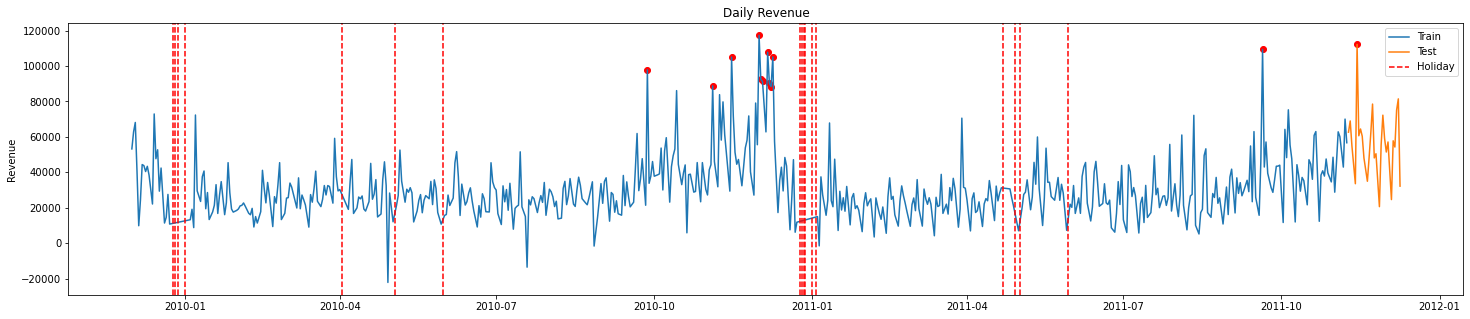

In [7]:
# split data into train and test and plot
# keep the last month data as test set
max_date = data['InvoiceDate'].max().date()
train = sales[:max_date -  relativedelta(months=1)][:-1]
test = sales[max_date - relativedelta(months=1):]
# plot daily revenue and holidays
uk_holidays = list(holidays.GB(years=[2009, 2010, 2011, 2012]).keys())
fig = plt.figure(figsize=(25, 5))
plt.plot(train)
plt.plot(test)
[plt.axvline(i, color='red', linestyle='--') for i in uk_holidays if i >= data['InvoiceDay'].min() and i <= data['InvoiceDay'].max()]
# plot outliers as point
plt.scatter(outliers, sales.loc[outliers], c='red', marker='o', label="Outliers")
plt.title('Daily Revenue')
plt.ylabel('Revenue')
plt.legend(['Train', 'Test', 'Holiday'])
plt.show()

In [8]:
uk_holidays = [i for i in uk_holidays if i >= data['InvoiceDay'].min() and i <= data['InvoiceDay'].max()]
# detect whether those holidays are shown in the data
def impute_holiday(data, holidays):
    dates = [i.date() for i in data.index]
    for i in holidays:
        if i not in dates:
            print(i)
impute_holiday(sales, uk_holidays)

2009-12-25
2009-12-26
2009-12-28
2010-01-01
2010-12-25
2010-12-27
2010-12-26
2010-12-28
2010-04-02
2010-05-03
2010-05-31
2011-04-29
2011-01-01
2011-01-03
2011-04-22
2011-05-02
2011-05-30


All these holidays is off.

In [9]:
# Add missing date to the data
sales = sales.resample('D').sum()
train = sales[:max_date -  relativedelta(months=1)][:-1]
test = sales[max_date - relativedelta(months=1):]

## ARIMA

In [10]:
#check stationarity
def check_stationarity(data):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print('Stationary')
    else:
        print('Non-Stationary')


### ACF and PACF plots

In [11]:
def acf_pacf_plot(data):
    fig, ax = plt.subplots(2,1,figsize=(20,10))
    plot_acf(data, ax=ax[0], lags=60)
    plot_pacf(data, ax=ax[1], lags=60)
    plt.show()


In [12]:
# auto arima
# stepwise_model = auto_arima(train, m=6, trace=True, suppress_warnings=True, stepwise=True)

In [13]:
# stepwise_model.plot_diagnostics(figsize=(15, 12))
# plt.show()

In [14]:
# predict the test_diff

def predict(stepwise_model, train, test):
    stepwise_model.fit(train)
    # check whether overfit
    forecast_train = stepwise_model.predict_in_sample()
    forecast_train = pd.DataFrame(forecast_train)
    forecast_train.index = train.index
    forecast_train.columns = ['Predict']

    forecast_test = stepwise_model.predict(n_periods=len(test))
    forecast_test = pd.DataFrame(forecast_test)
    forecast_test.index = test.index
    forecast_test.columns = ['Predict']

    forecast = pd.concat([forecast_train, forecast_test])

    return forecast, forecast_train, forecast_test
# # plot the predictions for test set
# plt.figure(figsize=(25,5))
# plt.plot(train, label='Train')
# plt.plot(test, label='Test')
# plt.plot(forecast, label='Prediction')
# plt.legend(loc='upper left')
# plt.show()


In [15]:
# calculate the MAPE, MAE, RMSE for training and test set
def calculate_error(test, forecast):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    
    # when test is 0, skip it for mape
    test_mape = test[test != 0]
    forecast_mape = forecast[test != 0]
    mape = np.mean(np.abs(test_mape - forecast_mape)/np.abs(test_mape))

    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

# mape_train, mae_train, rmse_train = calculate_error(train, forecast_train['Predict'])
# mape_test, mae_test, rmse_test = calculate_error(test, forecast_test['Predict'])

# # show the metrics in a table
# metrics = pd.DataFrame({'Train':[mape_train, mae_train, rmse_train], 'Test':[mape_test, mae_test, rmse_test]}, index=['MAPE', 'MAE', 'RMSE'])
# metrics

In [16]:
# plot the error
def plot_error(train, test, forecast, mape_test, mae_test, rmse_test, order, seasonal_order):
    plt.figure(figsize=(25,5))  
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(forecast, label='Prediction')
    # plot outliers as point
    plt.scatter(outliers, pd.concat([train, test]).loc[outliers], c='red', marker='o', label="Outliers")
    plt.legend(loc='upper left')
    plt.title('{}{} - MAPE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}'.format(order, seasonal_order, mape_test, mae_test, rmse_test))
    plt.show()

ADF Statistic: -3.038589
p-value: 0.031444
Stationary
ADF Statistic: -8.163569
p-value: 0.000000
Stationary


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


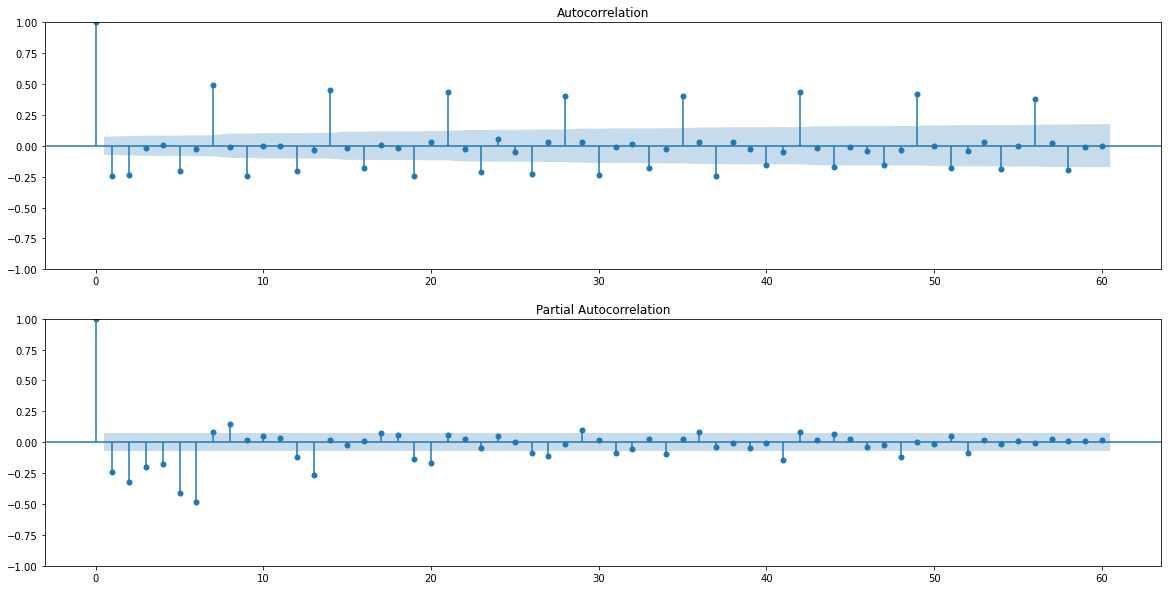

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=15633.588, Time=1.14 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=16019.204, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=15712.715, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=15766.714, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=16696.918, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=15742.049, Time=0.59 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=15659.971, Time=0.58 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=15633.296, Time=1.77 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=15634.555, Time=1.16 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=3.29 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=15635.588, Time=1.84 sec
 ARIMA(1,0,2)(2,0,1)[7] intercept   : AIC=15634.806, Time=1.17 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=15644.228, Time=1.43 sec
 ARIMA(3,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(2,0,3)(2,0,1)[7] interce

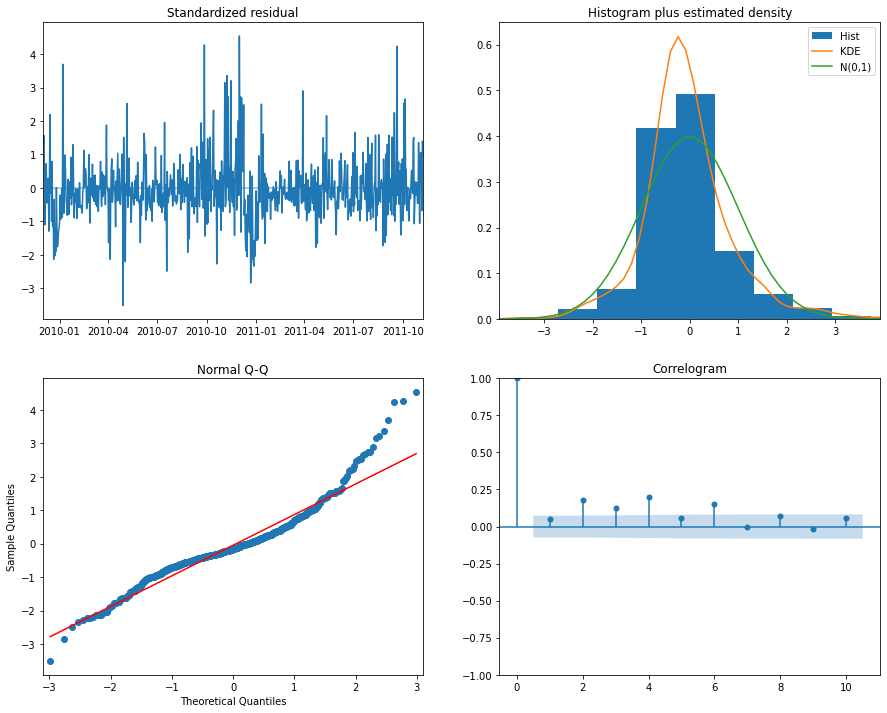

             Train          Test
MAPE      0.433212      0.275675
MAE    9950.657313  16334.132303
RMSE  14125.290923  21102.952214
(2, 0, 3) (1, 0, 2, 7)


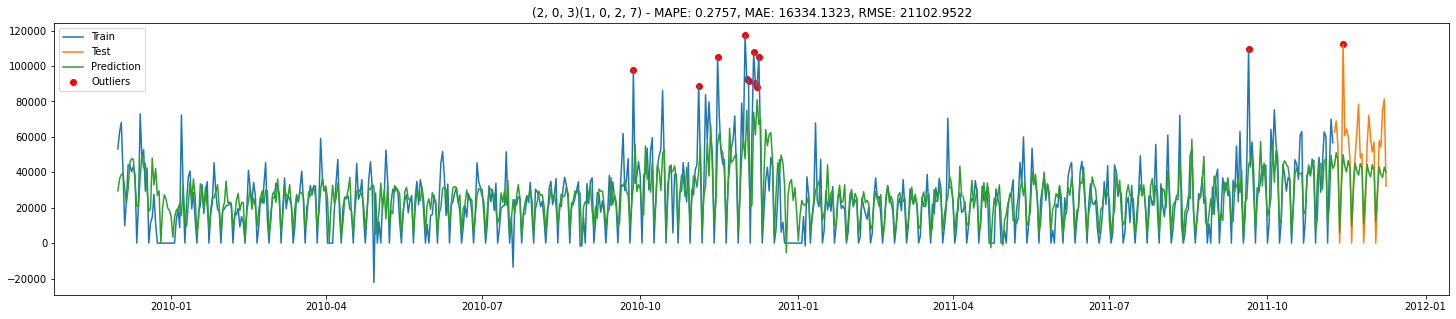

In [17]:
check_stationarity(train)
check_stationarity(train.diff().dropna())
acf_pacf_plot(train.diff().dropna())

stepwise_model = auto_arima(train, m=7, trace=True, suppress_warnings=True, stepwise=True)
stepwise_model.plot_diagnostics(figsize=(15, 12))
plt.show()

forecast, forecast_train, forecast_test = predict(stepwise_model, train, test)

mape_train, mae_train, rmse_train = calculate_error(train, forecast_train['Predict'])
mape_test, mae_test, rmse_test = calculate_error(test, forecast_test['Predict'])
metrics = pd.DataFrame({'Train':[mape_train, mae_train, rmse_train], 'Test':[mape_test, mae_test, rmse_test]}, index=['MAPE', 'MAE', 'RMSE'])
print(metrics)

print(stepwise_model.order, stepwise_model.seasonal_order)
plot_error(train, test, forecast, mape_test, mae_test, rmse_test, stepwise_model.order, stepwise_model.seasonal_order)

# ARIMAX

In [18]:
# add holidays and Saturday as exogenous variables
sales = pd.DataFrame(sales)
# 1 if it is a holiday, else 0
sales['Holiday'] = sales.index.map(lambda x: 1 if x.date() in uk_holidays else 0)
# 1 if it is a Saturday, else 0
sales['Saturday'] = sales.index.map(lambda x: 1 if x.weekday() == 5 else 0)

In [19]:
# split 
train = sales[:max_date -  relativedelta(months=1)][:-1]
test = sales[max_date - relativedelta(months=1):]

In [20]:
def predict_ARIMAX(train, test, exogenous):
    stepwise_model.fit(train['Revenue'], train[exogenous])
    # check whether overfit
    forecast_train = stepwise_model.predict_in_sample(X=train[exogenous])
    forecast_train = pd.DataFrame(forecast_train)
    forecast_train.index = train.index
    forecast_train.columns = ['Predict']

    forecast_test = stepwise_model.predict(n_periods=len(test), X=test[exogenous])
    forecast_test = pd.DataFrame(forecast_test)
    forecast_test.index = test.index
    forecast_test.columns = ['Predict']

    forecast = pd.concat([forecast_train, forecast_test])

    return forecast, forecast_train, forecast_test

ADF Statistic: -3.038589
p-value: 0.031444
Stationary
ADF Statistic: -8.163569
p-value: 0.000000
Stationary


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


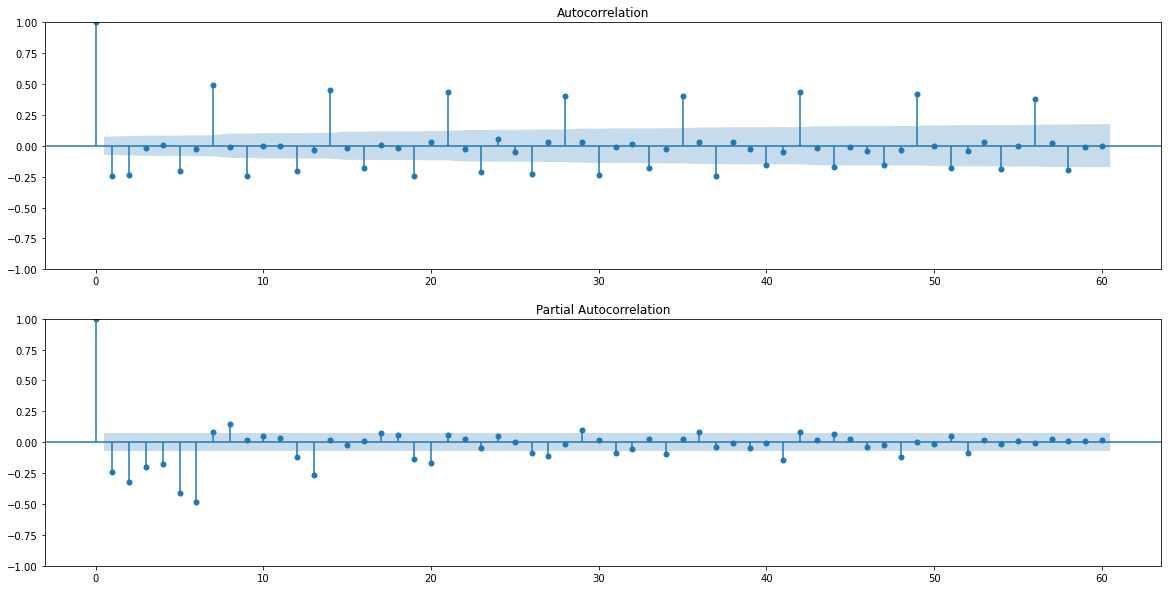

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=15638.394, Time=1.31 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=16024.429, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=15717.751, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=15771.702, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=20640.128, Time=0.05 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=15747.206, Time=0.62 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=15664.757, Time=0.58 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=15638.096, Time=2.14 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=15639.336, Time=1.39 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=3.87 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=15640.391, Time=3.16 sec
 ARIMA(1,0,2)(2,0,1)[7] intercept   : AIC=15639.561, Time=1.83 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=15649.043, Time=1.90 sec
 ARIMA(3,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(2,0,3)(2,0,1)[7] interce

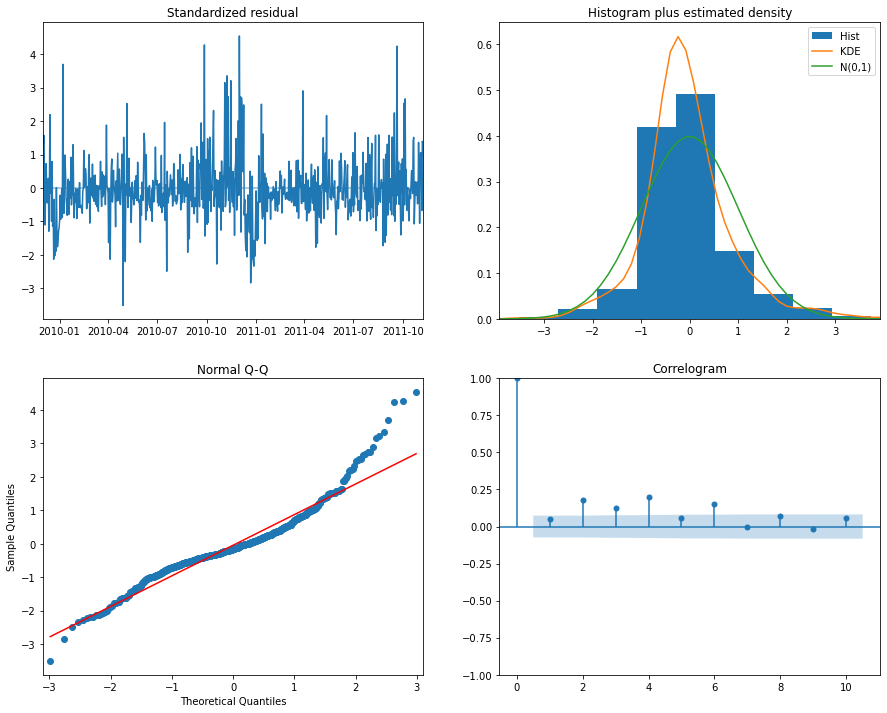

             Train          Test
MAPE      0.433091      0.276007
MAE    9952.665928  16357.945701
RMSE  14126.866362  21127.526428
(2, 0, 3) (1, 0, 2, 7)


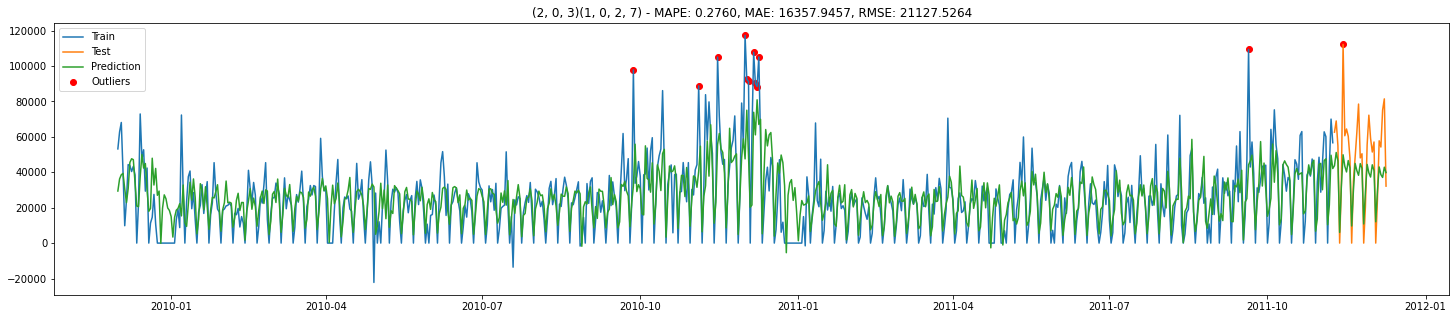

In [21]:
# same as ARIMA
check_stationarity(train['Revenue'])
check_stationarity(train['Revenue'].diff().dropna())
acf_pacf_plot(train['Revenue'].diff().dropna())

stepwise_model = auto_arima(train['Revenue'], X=train[['Holiday', 'Saturday']], m=7, trace=True, suppress_warnings=True, stepwise=True, test='adf')
stepwise_model.plot_diagnostics(figsize=(15, 12))
plt.show()

forecast, forecast_train, forecast_test = predict_ARIMAX(train, test, ['Holiday', 'Saturday'])

mape_train, mae_train, rmse_train = calculate_error(train['Revenue'], forecast_train['Predict'])
mape_test, mae_test, rmse_test = calculate_error(test['Revenue'], forecast_test['Predict'])
metrics = pd.DataFrame({'Train':[mape_train, mae_train, rmse_train], 'Test':[mape_test, mae_test, rmse_test]}, index=['MAPE', 'MAE', 'RMSE'])
print(metrics)

print(stepwise_model.order, stepwise_model.seasonal_order)
plot_error(train['Revenue'], test['Revenue'], forecast, mape_test, mae_test, rmse_test, stepwise_model.order, stepwise_model.seasonal_order)

ADF Statistic: -3.038589
p-value: 0.031444
Stationary
ADF Statistic: -8.163569
p-value: 0.000000
Stationary


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


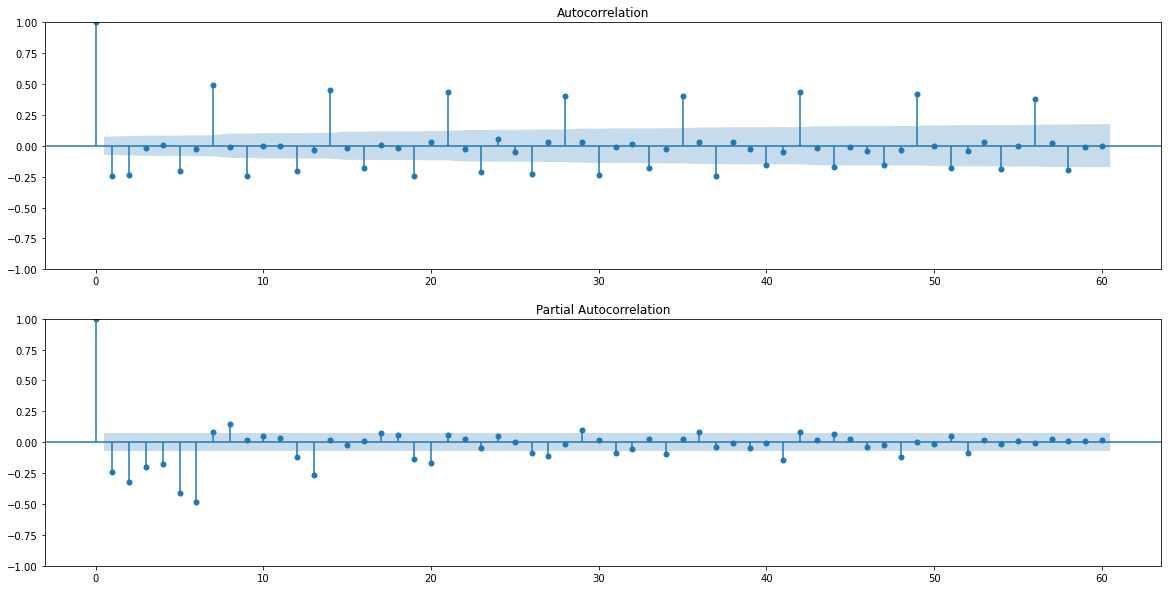

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=15831.349, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=15663.940, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=15554.536, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=19761.998, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=15597.340, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=15546.166, Time=0.62 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=15778.916, Time=0.45 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=15523.427, Time=0.83 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=15531.602, Time=0.53 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=15670.0

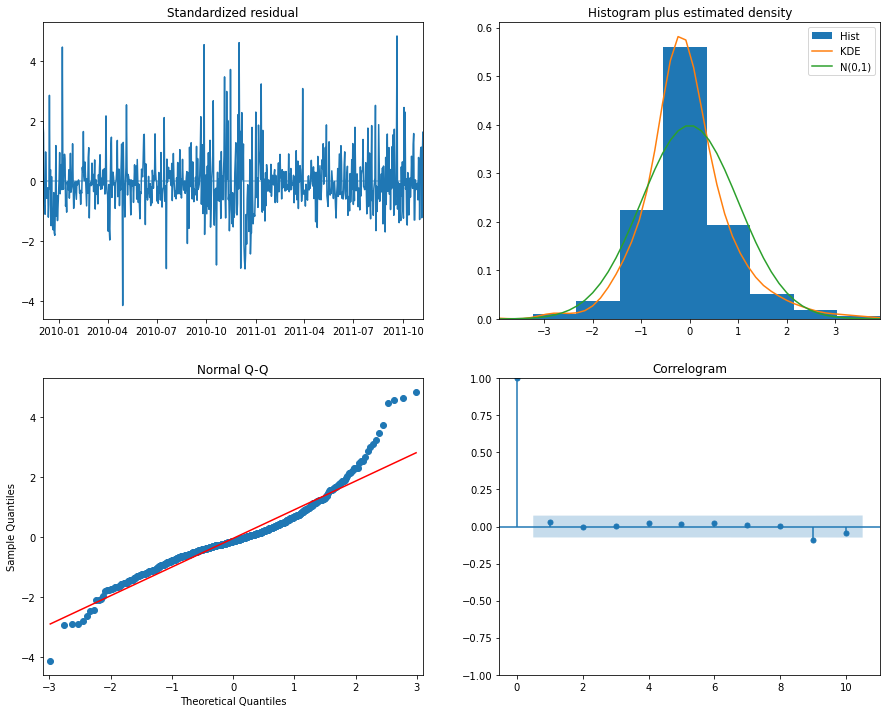

             Train          Test
MAPE      0.423512      0.263645
MAE    9356.686643  13725.584615
RMSE  13456.621730  17979.098205
(2, 1, 2) (2, 0, 1, 7)


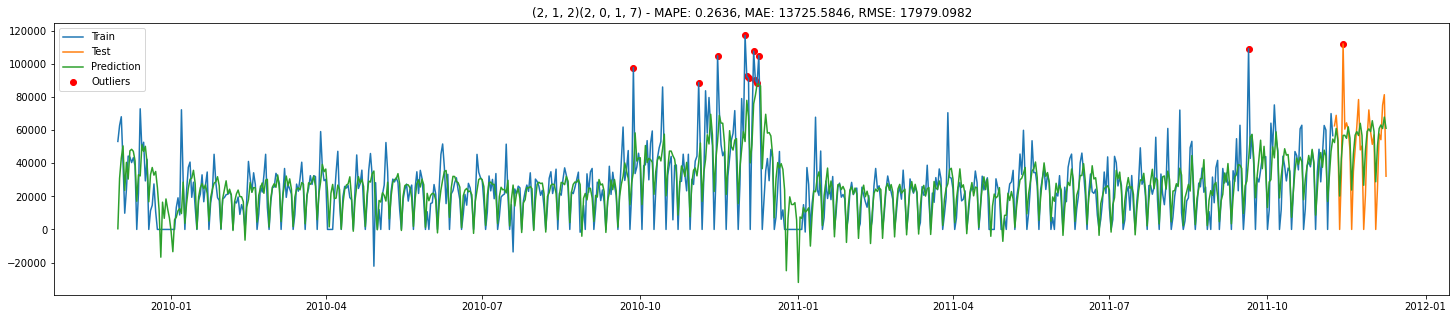

In [22]:
# same as ARIMA
check_stationarity(train['Revenue'])
check_stationarity(train['Revenue'].diff().dropna())
acf_pacf_plot(train['Revenue'].diff().dropna())

stepwise_model = auto_arima(train['Revenue'], X=train[['Holiday', 'Saturday']], m=7, trace=True, suppress_warnings=True, stepwise=True)
stepwise_model.plot_diagnostics(figsize=(15, 12))
plt.show()

forecast, forecast_train, forecast_test = predict_ARIMAX(train, test, ['Holiday', 'Saturday'])

mape_train, mae_train, rmse_train = calculate_error(train['Revenue'], forecast_train['Predict'])
mape_test, mae_test, rmse_test = calculate_error(test['Revenue'], forecast_test['Predict'])
metrics = pd.DataFrame({'Train':[mape_train, mae_train, rmse_train], 'Test':[mape_test, mae_test, rmse_test]}, index=['MAPE', 'MAE', 'RMSE'])
print(metrics)

print(stepwise_model.order, stepwise_model.seasonal_order)
plot_error(train['Revenue'], test['Revenue'], forecast, mape_test, mae_test, rmse_test, stepwise_model.order, stepwise_model.seasonal_order)

# Holt Winters

In [23]:
# remove negative sales in order to use mupltiplicative model
# add minimum negative sales to all sales
pos_sales = sales.copy()
min_sales = sales['Revenue'].min() - 0.01
pos_sales['Revenue'] = pos_sales['Revenue'] + np.abs(min_sales)


In [24]:
# split
pos_train = pos_sales[:max_date -  relativedelta(months=1)][:-1]['Revenue']
pos_test = pos_sales[max_date - relativedelta(months=1):]['Revenue']

In [25]:
# ETS models
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import itertools

# Define a list of hyperparameters to search through
error = ['add', 'mul']
trend = ['add', 'additive', 'mul', None]
seasonal = ['add', 'additive', 'mul', None]
seasonal_periods = [7]  # Modify this based on your data's seasonality
param_grid = list(itertools.product(error, trend, seasonal, seasonal_periods))

best_aic = float("inf")
for param in param_grid:
    try:
        if param[2] == None: # seasonal is None
            model = ETSModel(pos_train, error=param[0], trend=param[1])
        else:
            model = ETSModel(pos_train, error=param[0], trend=param[1], seasonal=param[2], seasonal_periods=param[3])
        results = model.fit(disp=0)
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_error = param[0]
            best_trend = param[1]
            best_seasonal = param[2]
            best_model = results
    except:
        print('wrong parameters:', param)
        continue

# print the best model
print(best_model.summary())

                                 ETS Results                                  
Dep. Variable:                Revenue   No. Observations:                  708
Model:                       ETS(MNM)   Log Likelihood               -7594.475
Date:                Sat, 28 Oct 2023   AIC                          15210.950
Time:                        11:16:56   BIC                          15261.137
Sample:                    12-01-2009   HQIC                         15230.340
                         - 11-08-2011   Scale                            0.062
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.1989      0.030      6.588      0.000       0.140       0.258
smoothing_seasonal  8.011e-05        nan        nan        nan         nan         nan
initial_level       

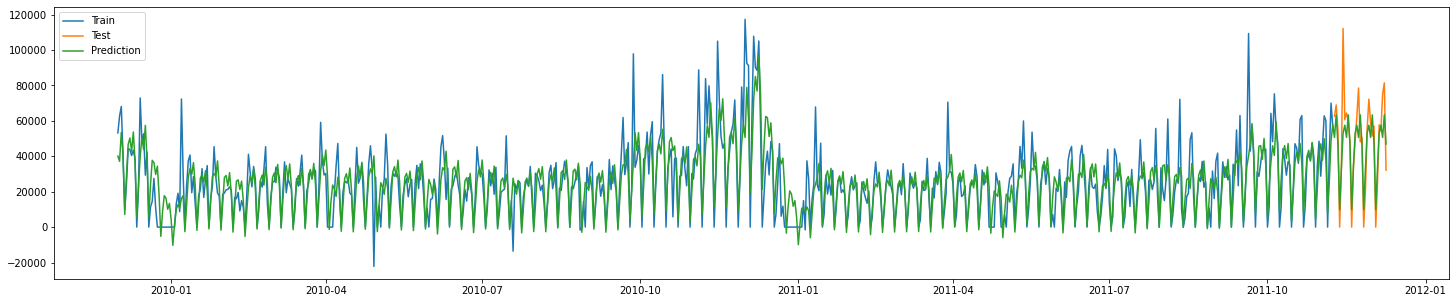

In [26]:
# predict
forecast_train = best_model.predict(start=pos_train.index[0], end=pos_train.index[-1])
forecast_train = pd.DataFrame(forecast_train - np.abs(min_sales), columns=['Predict'])

forecast_test = best_model.predict(start=pos_test.index[0], end=pos_test.index[-1])
forecast_test = pd.DataFrame(forecast_test - np.abs(min_sales), columns=['Predict'])

forecast = pd.concat([forecast_train, forecast_test])

# plot the predictions for test set
plt.figure(figsize=(25,5))
plt.plot(train['Revenue'], label='Train')
plt.plot(test['Revenue'], label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='upper left')
plt.show()


In [27]:
# calculate the MAPE, MAE, RMSE for training and test set
mape_train, mae_train, rmse_train = calculate_error(train['Revenue'], forecast_train['Predict'])
mape_test, mae_test, rmse_test = calculate_error(test['Revenue'], forecast_test['Predict'])
metrics = pd.DataFrame({'Train':[mape_train, mae_train, rmse_train], 'Test':[mape_test, mae_test, rmse_test]}, index=['MAPE', 'MAE', 'RMSE'])
print(metrics)

             Train          Test
MAPE      0.391006      0.191006
MAE    8588.526830  10885.999716
RMSE  12520.943451  15373.494692


In [28]:
print(best_aic, best_error, best_trend, best_seasonal)

15210.949861992414 mul None mul


# FB-Prophet

In [29]:
m = Prophet()
m.add_country_holidays(country_name='GB')
# future = m.make_future_dataframe(periods=len(test))
forecast = m.fit(train.reset_index().rename(columns={'InvoiceDay':'ds', 'Revenue':'y'})).predict(m.make_future_dataframe(periods=len(test)))

11:16:56 - cmdstanpy - INFO - Chain [1] start processing
11:16:57 - cmdstanpy - INFO - Chain [1] done processing


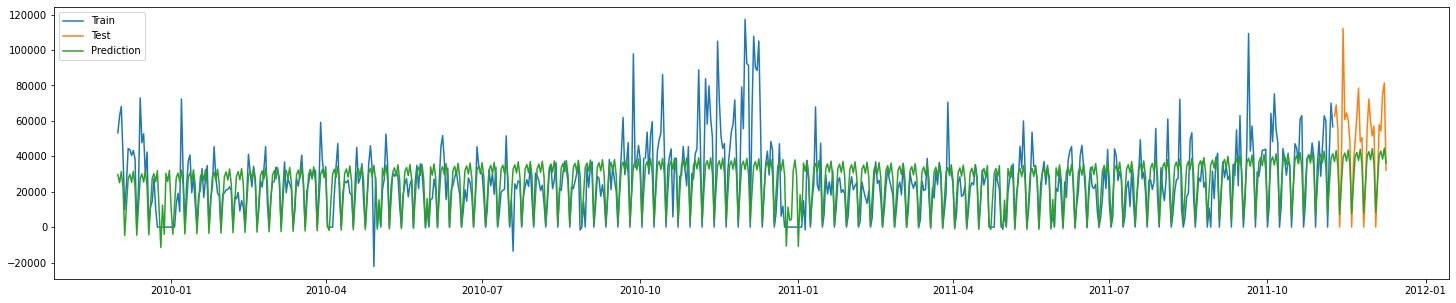

In [30]:
#plot
plt.figure(figsize=(25,5))
plt.plot(train['Revenue'], label='Train')
plt.plot(test['Revenue'], label='Test')
plt.plot(pd.DataFrame(forecast['yhat'].values, index=forecast['ds']), label='Prediction')
plt.legend(loc='upper left')
plt.show()


In [31]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

In [32]:
plot_components_plotly(m, forecast)

In [33]:
mape_train, mae_train, rmse_train = calculate_error(train['Revenue'], pd.DataFrame(forecast[forecast['ds'].isin(train.index)]['yhat'].values, index=train.index, columns=['Predict'])['Predict'])
mape_test, mae_test, rmse_test = calculate_error(test['Revenue'], pd.DataFrame(forecast[forecast['ds'].isin(test.index)]['yhat'].values, index=test.index, columns=['Predict'])['Predict'])
metrics = pd.DataFrame({'Train':[mape_train, mae_train, rmse_train], 'Test':[mape_test, mae_test, rmse_test]}, index=['MAPE', 'MAE', 'RMSE'])
print(metrics)

             Train          Test
MAPE      0.497157      0.312442
MAE    9972.143738  18264.021892
RMSE  14811.703913  23199.086830


# LSTM

In [34]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [167]:
min_max_scaler = MinMaxScaler()
scaler_train = min_max_scaler.fit_transform(train['Revenue'].values.reshape(-1,1))
scaler_test = min_max_scaler.transform(test['Revenue'].values.reshape(-1,1))

# LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X_train, y_train = create_dataset(scaler_train, scaler_train, time_steps)
X_test, y_test = create_dataset(scaler_test, scaler_test, time_steps)

model = Sequential()
model.add(LSTM(units=8, input_shape=(X_train.shape[1], X_train.shape[2])))
# , return_sequences=True
# model.add(LSTM(units=4, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, shuffle=False)

test_predictions = []
first_eval_batch = scaler_train[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, 1))

for i in range(len(test)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_test_predictions = min_max_scaler.inverse_transform(test_predictions)
test['Predictions'] = true_test_predictions

# train_predictions = []
# first_eval_batch = scaler_train[:time_steps]
# current_batch = first_eval_batch.reshape((1, time_steps, 1))

# for i in range(len(train)-time_steps):
#     # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
#     current_pred = model.predict(current_batch)[0]
    
#     # store prediction
#     train_predictions.append(current_pred) 
    
#     # update batch to now include prediction and drop first value
#     current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# true_train_predictions = min_max_scaler.inverse_transform(train_predictions)
# train['Predictions'] = np.append(np.array([np.NaN] * time_steps).reshape(time_steps, 1), true_train_predictions)

Epoch 1/100
44/44 [==============================] - 1s 1ms/step - loss: 0.0743
Epoch 2/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 3/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0171
Epoch 4/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0171
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 6/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0170
Epoch 7/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0169
Epoch 8/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 9/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 10/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 11/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 12/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 13/100
44/44 [=================

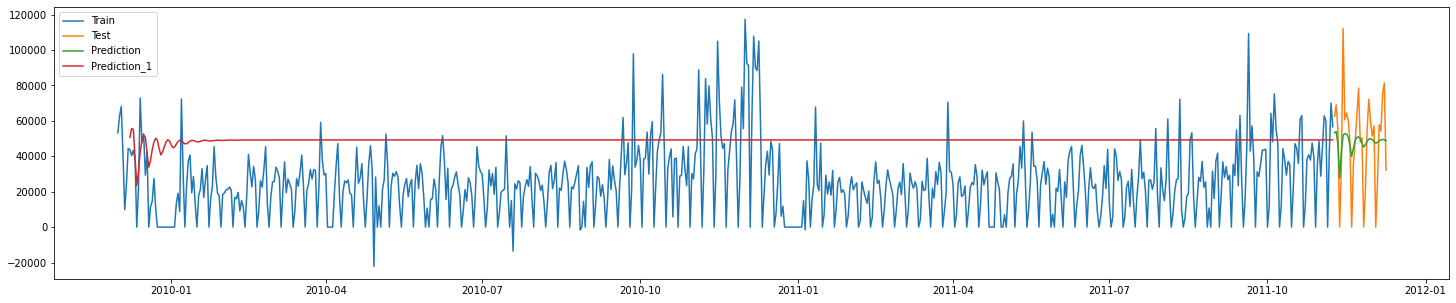

In [ ]:
# plot the predictions for test set
plt.figure(figsize=(25,5))
plt.plot(train['Revenue'], label='Train')
plt.plot(test['Revenue'], label='Test')
plt.plot(test['Predictions'], label='Prediction')
# plt.plot(train['Predictions'], label='Prediction_1')
plt.legend(loc='upper left')
plt.show()


In [ ]:
rmse_lstm = np.sqrt(mean_squared_error(test['Revenue'], test['Predictions']))
mape_lstm = np.mean(np.abs(test[test['Revenue']!=0]['Revenue'] - test[test['Revenue']!=0]['Predictions'])/np.abs(test[test['Revenue']!=0]['Revenue']))
mae_lstm = mean_absolute_error(test['Revenue'], test['Predictions'])
print('RMSE: {:.4f}, MAPE: {:.4f}, MAE: {:.4f}'.format(rmse_lstm, mape_lstm, mae_lstm))

RMSE: 35389.2236, MAPE: 0.5144, MAE: 31092.9433


In [ ]:
RMSE: 46213.7677, MAPE: 0.8351, MAE: 39997.2017
RMSE: 30020.9429, MAPE: 0.4627, MAE: 22630.3090
RMSE: 24184.9389, MAPE: 0.4141, MAE: 18570.0122 # 16 units, 2 layers
RMSE: 26284.1345, MAPE: 0.3524, MAE: 19051.6063 # 16 units, 1 layer
RMSE: 22278.3895, MAPE: 0.2561, MAE: 15611.9452 # 8 units, 1 layer